## Import

In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import ttach as tta

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import KFold, train_test_split

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from joblib import Parallel, delayed

import segmentation_models_pytorch as smp
import argparse
import ssl

from sklearn.metrics import f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Hyperparameter Setting

In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':1,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':8,
    'SEED':41
}

## Fix Randomseed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Utils

In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Data Load

In [ ]:
train_data = pd.read_csv('train.csv')

X_train = train_data.drop('mask_rle', axis=1)
y_train = train_data['mask_rle']

## Custom Dataset

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
class SatelliteDataset2(Dataset):
    def __init__(self, df, transform=None, infer=False):
        self.df = df
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.df.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.RandomCrop(224, 224, p=1),
        A.Normalize(),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [

        A.CenterCrop(224, 224, p=1),
        A.Normalize(),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

## Data Loader

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

BaseModel = smp.Unet(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    in_channels = 3,
    classes = 1,
    activation = ACTIVATION,
)

##Loss Function

In [ ]:
import re

class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)

In [ ]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


jaccard = iou


def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta**2) * tp + eps) / ((1 + beta**2) * tp + beta**2 * fn + fp + eps)

    return score


def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score


def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score


def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [ ]:
class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )

In [ ]:
class FocalLoss(Loss):
    def __init__(self, alpha=1, gamma=2, class_weights=None, logits=False, reduction='mean'):
        super().__init__()
        assert reduction in ['mean', None]
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction
        self.class_weights = class_weights if class_weights is not None else 1.

    def forward(self, y_pr, y_gt):
        bce_loss = nn.functional.binary_cross_entropy(y_pr, y_gt)

        pt = torch.exp(- bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        focal_loss = focal_loss * torch.tensor(self.class_weights).to(focal_loss.device)

        if self.reduction == 'mean':
            focal_loss = focal_loss.mean()

        return focal_loss

##CutMix

In [ ]:
def cutmix(batch, alpha=1.0, p=0):
    '''
    alpha 값을 1.0으로 설정하여 beta 분포가 uniform 분포가 되도록 함으로써,
    두 이미지를 랜덤하게 combine하는 Cutmix
    '''

    data, targets = batch

    # cutmix 확률 설정
    if np.random.random() > p:
        return data, (targets, torch.zeros_like(targets), 1.0)

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)

    return data, targets


class CutMixCollator:
    def __init__(self, alpha, p):
        self.alpha = alpha
        self.p = p

    def __call__(self, batch):
        batch = torch.utils.data.dataloader.default_collate(batch)
        batch = cutmix(batch, self.alpha, self.p)
        return batch

In [ ]:
dice = DiceLoss()
focal = FocalLoss()
base_criterion = dice + focal

class CutMixCriterion:
    def __init__(self):
        self.criterion = base_criterion

    def __call__(self, preds, targets):
        targets1, targets2, lam = targets
        targets1 = targets1.unsqueeze(1)
        targets2 = targets2.unsqueeze(1)
        return lam * self.criterion(
            preds, targets1) + (1 - lam) * self.criterion(preds, targets2)


In [ ]:
collator = CutMixCollator(alpha=1.0, p=0.5)

## Model Train

In [ ]:
train_data = pd.read_csv('train.csv')

X_train = train_data.drop('mask_rle', axis=1)
y_train = train_data['mask_rle']

In [ ]:
def train_1epoch(model, train_loader, lossfun, optimizer, device):
    print('train')
    model.train()
    model.to('cuda')
    train_loss = []

    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        targets1, targets2, lam = masks # cutmix하기 위해 label split
        masks = (targets1.float().to(device), targets2.float().to(device), lam)

        optimizer.zero_grad()
        outputs = model(images)
        loss = lossfun(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    tr_loss = np.mean(train_loss)
    return tr_loss

def validate_1epoch(model, val_loader, lossfun, device):
    print('validate')
    model.eval()
    model.to(device)

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = lossfun(outputs, masks.unsqueeze(1))

            val_loss.append(loss.item())


    val_score = f_score(outputs, masks.unsqueeze(1), beta=1, eps=1e-7, threshold=None, ignore_channels=None)

    return np.mean(val_loss), val_score

In [ ]:
# Test Time Augmentation
tta_transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 90, 180]),
        #tta.Scale(scales=[1,2,4])
    ]
)

def predict(model, loader, device):
    all_predictions = []

    with torch.no_grad():
        model.eval()

        tta_model = tta.SegmentationTTAWrapper(model, tta_transforms)
        tta_model.to(device)
        for images in tqdm(loader):
            images = images.float().to(device)

            outputs = tta_model(images)
            outputs = outputs.cpu().numpy()
            outputs = np.squeeze(outputs, axis=1)
            all_predictions.extend(outputs)

    fold_pred =     (all_predictions)

    return fold_pred

In [ ]:
test_ds = SatelliteDataset(csv_file='test.csv', transform=test_transform, infer=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)

def getDataloader(train_idx, valid_idx, batch_size, num_workers, collator):

    train_df, val_df = train_data.loc[train_idx], train_data.loc[valid_idx]

    # train_transform이 적용된 train_transform_dataset에서 train_idx에 해당하는 Subset 추출
    train_ds = SatelliteDataset2(train_df, transform=train_transform)
    # val_transform이 적용된 val_transform_dataset에서 valid_idx에 해당하는 Subset 추출
    val_ds   = SatelliteDataset2(val_df, transform=val_transform)

    # 추출된 Train Subset으로 DataLoader 생성
    train_dl = DataLoader(train_ds,
                              batch_size = batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              collate_fn = collator)
    # 추출된 Valid Subset으로 DataLoader 생성
    val_dl = DataLoader(val_ds,
                            batch_size= batch_size,
                            shuffle=False,
                            num_workers=num_workers)

    # 생성한 DataLoader 반환
    return train_dl, val_dl

def train_kfold(device):

    n_splits = 5
    kf = KFold(n_splits)

    train_criterion = CutMixCriterion()
    val_criterion = base_criterion

    patience = 10  # 10 epoch동안 성능 향상 없을 시, early stopping
    oof_pred = None

    for fold_id, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):

        model = BaseModel
        model.
        train_loader, val_loader = getDataloader(train_idx, valid_idx, batch_size=CFG['BATCH_SIZE'], num_workers=4, collator=collator)

        optimizer = torch.optim.AdamW([dict(params=model.parameters(), lr=0.0001, weight_decay = 0.0002),])
        scheduler = None

        train_losses = []
        valid_losses = []

        best_score = 0
        best_model = None
        counter = 0

        for epoch in range(1,CFG["EPOCHS"]+1):

            '''
            tr_loss = train_1epoch(
                model, train_loader, train_criterion, optimizer, device
            )
            '''

            val_loss, val_score = validate_1epoch(
                model, val_loader, val_criterion, device
            )

            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Dice Score : [{val_score:.5f}]')

            torch.save(model.state_dict(), f'kf{n_splits}_epoch{CFG["EPOCHS"]}_fold{fold_id}_epoch{epoch}.pth')

            if scheduler is not None:
                scheduler.step()

            if best_score < val_score:
                best_model = model
                best_score = val_score
                counter=0
                # 갱신 시마다  best model 저장 -> fold별 마지막 weight이 fold별 best weight
                torch.save(model, f"weights/fold{fold_id}_{epoch:03}_f1score_{val_score:4.2%}.pt")
            else:
                counter+=1

            if counter > patience:
                print("Early Stopping...")
                break


        fold_pred = predict(best_model, test_dl, device)

        # OOF
        if oof_pred is None:
            oof_pred = fold_pred / n_splits
        else:
            oof_pred += fold_pred / n_splits

    oof_pred = (oof_pred > 0.25).astype(np.uint8) # Threshold = 0.25

    # Morphological Transformation - Closing
    #kernel = np.ones((5,5), np.uint8)
    #oof_pred = cv2.morphologyEx(oof_pred, cv2.MORPH_CLOSE, kernel)

    result = []

    for i in range(len(images)):
        oof_pred = rle_encode(masks[i])
        if moof_pred == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
            result.append(-1)
        else:
            result.append(oof_pred)

In [ ]:
train_kfold('cuda')

train


 28%|███████████▍                             | 200/714 [01:06<02:46,  3.08it/s]

In [ ]:
torch.save(model.state_dict(), 'kf5_epoch30+tta+closing5.pth')

In [ ]:
model.load_state_dict(torch.load('ef7+dicefocal+adamW+wd0_0002+kf5+rnd224+tta_try1.pth'))

<All keys matched successfully>

##Inference

##Submission

In [ ]:
submit = pd.read_csv('sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('kf5_epoch30+tta+closing5.csv', index=False)

/tmp/ipykernel_4679/1394352983.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


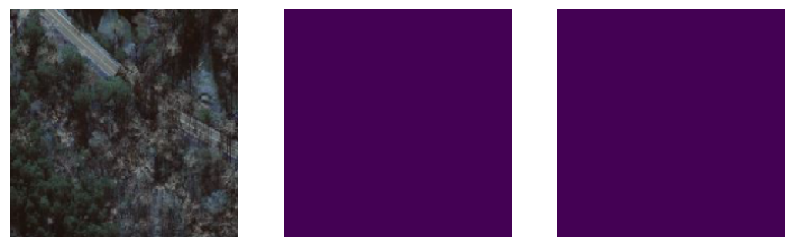

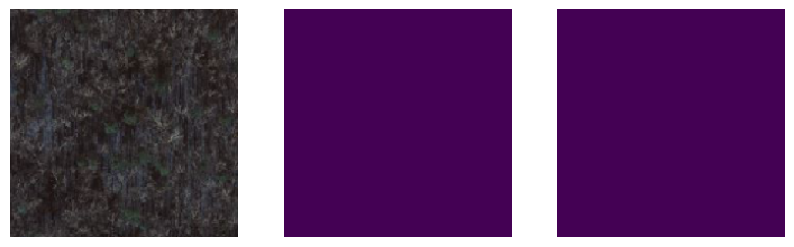

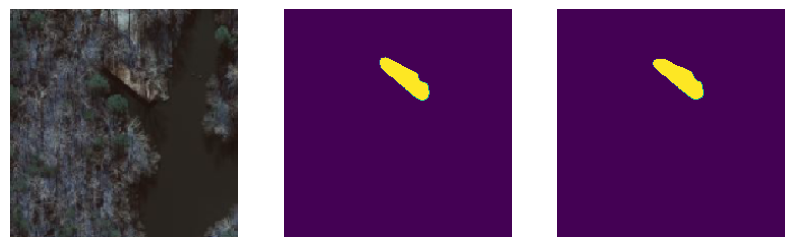

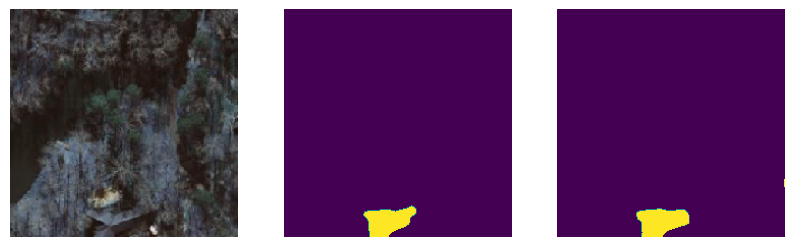

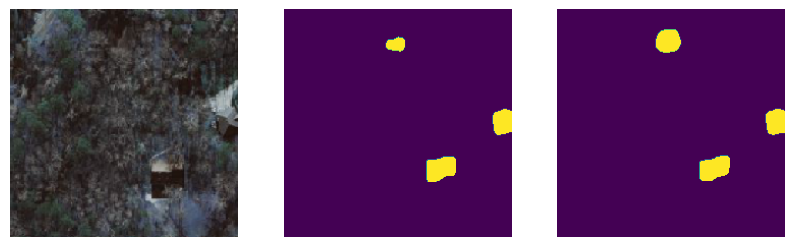

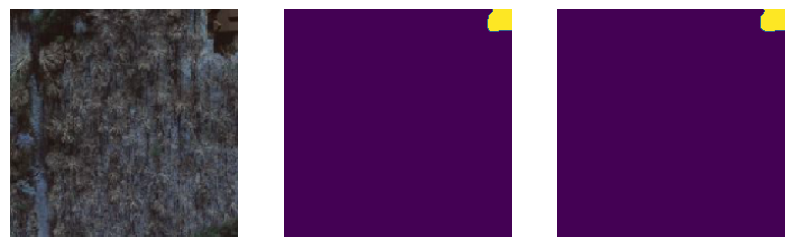

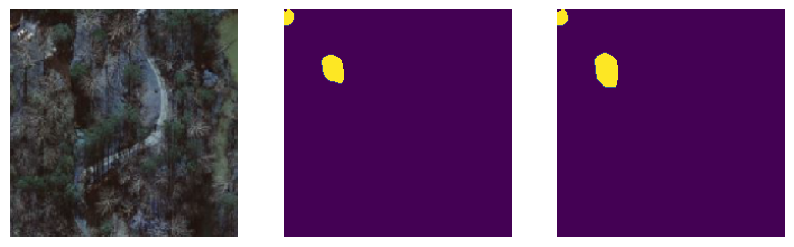

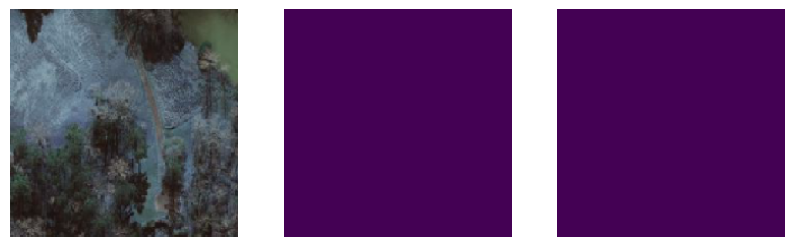

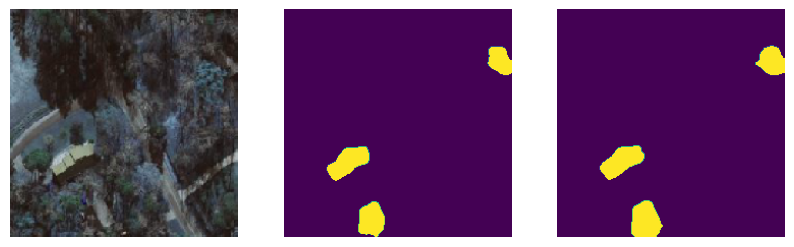

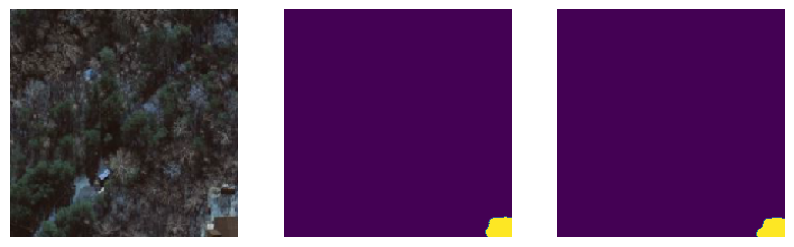

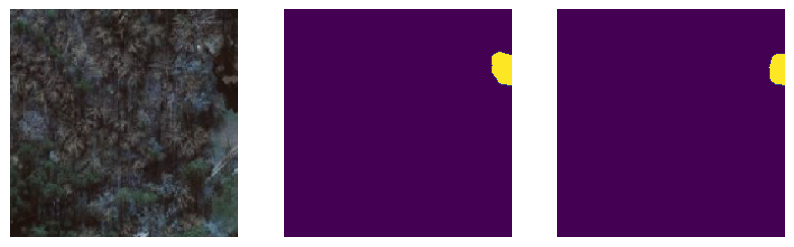

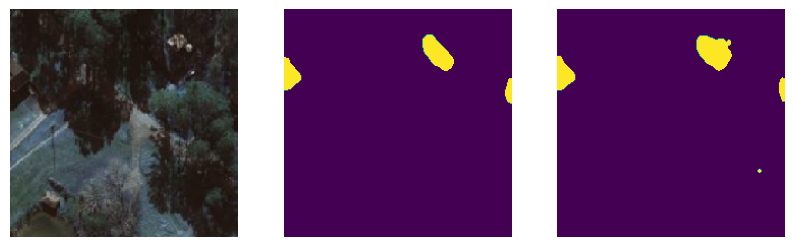

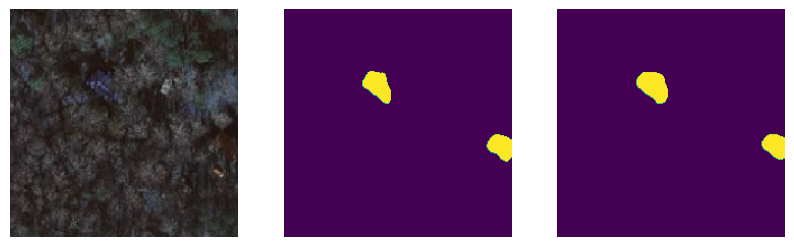

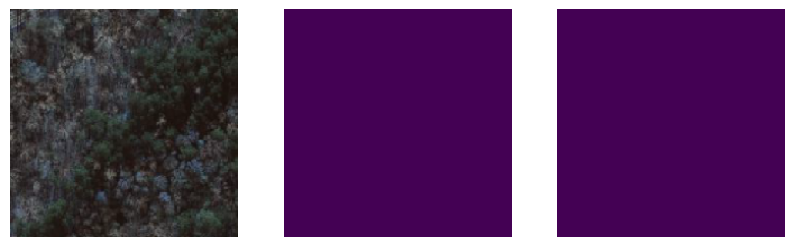

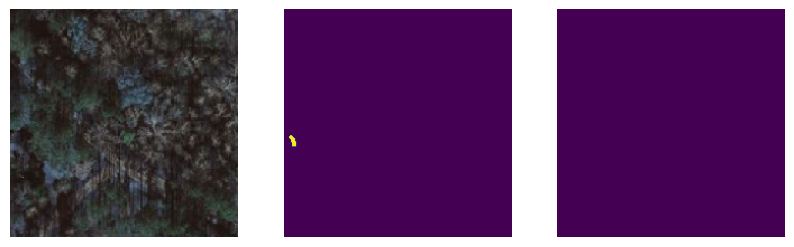

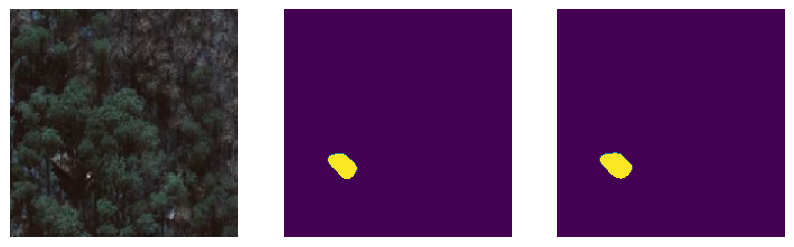

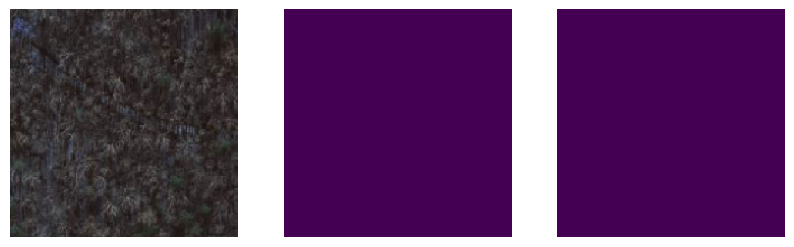

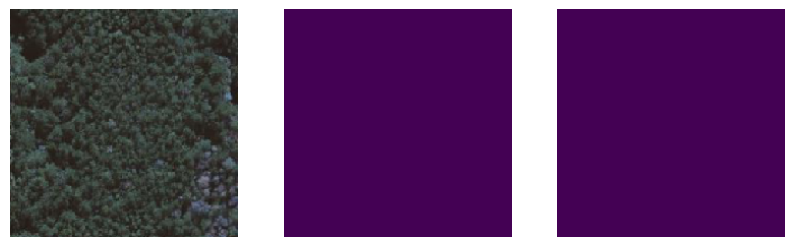

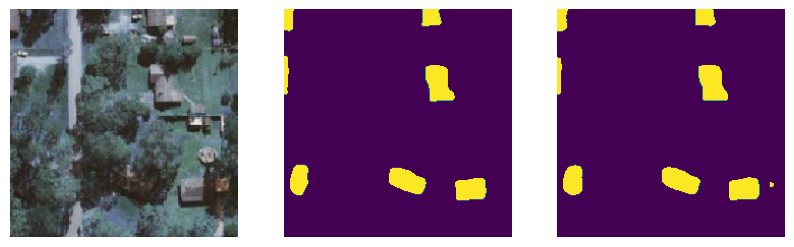

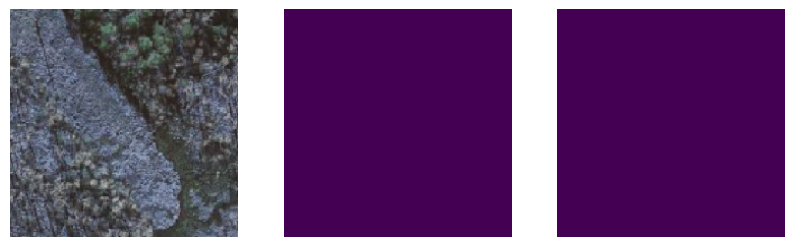

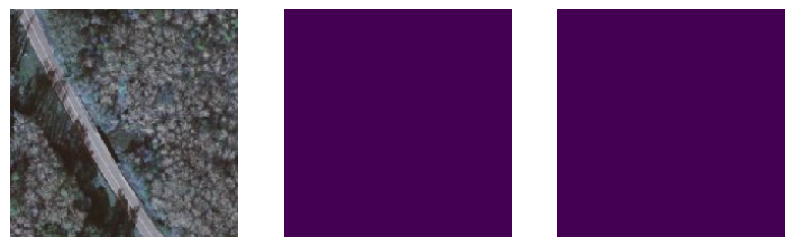

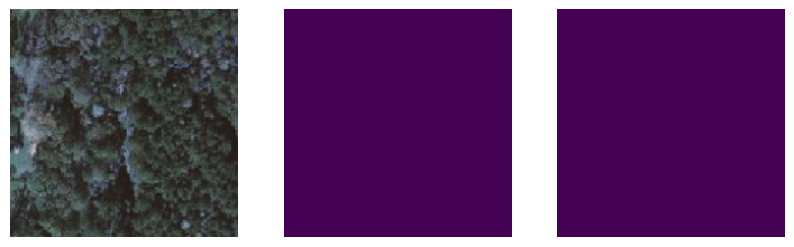

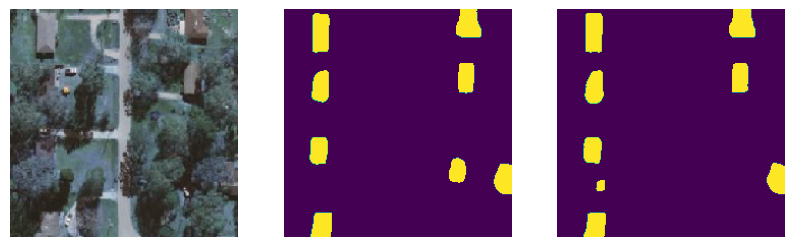

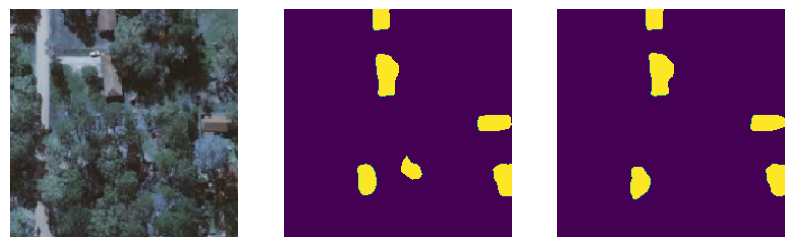

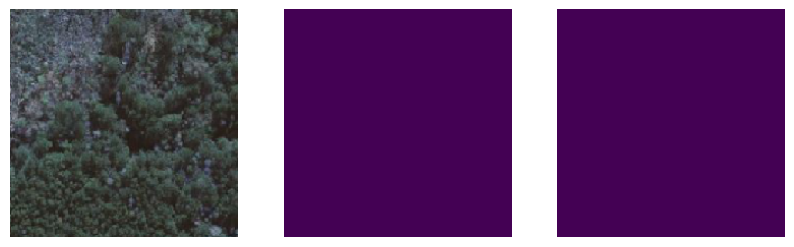

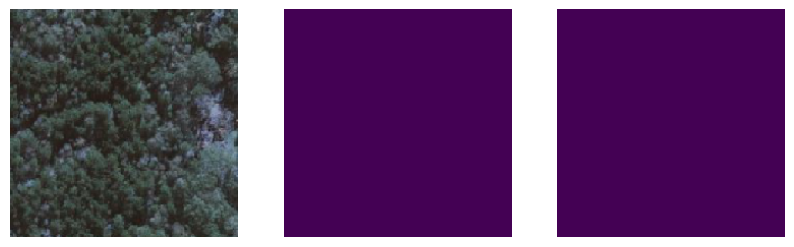

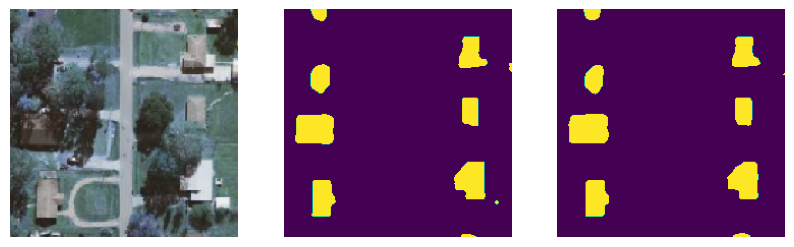

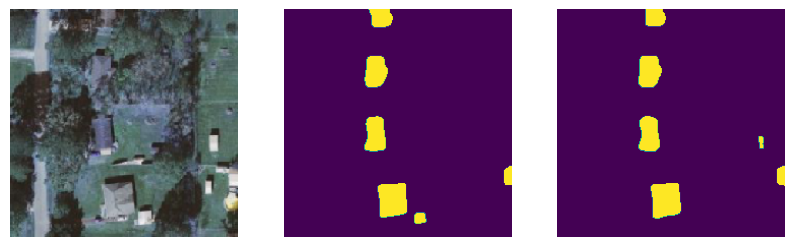

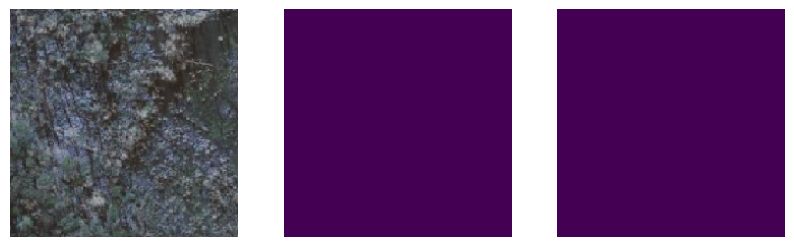

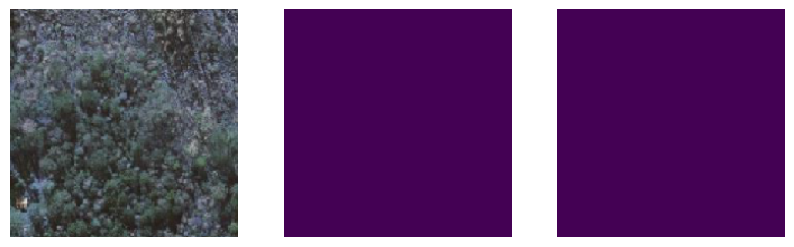

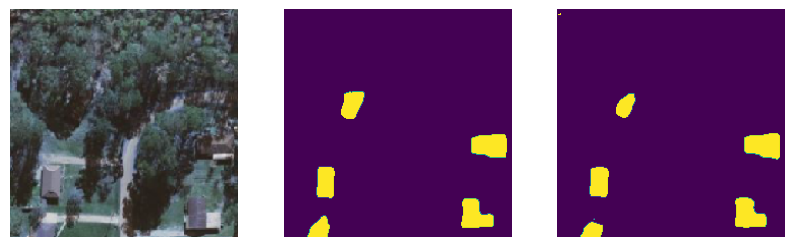

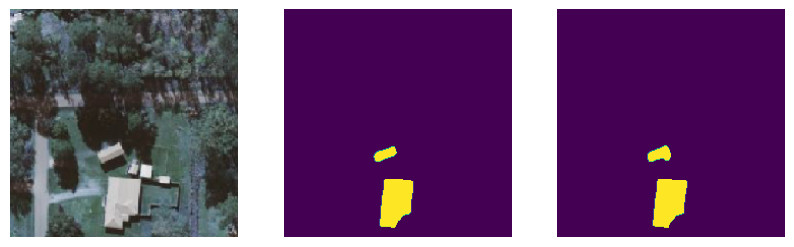

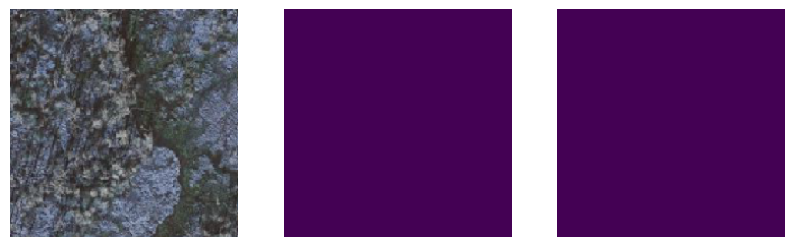

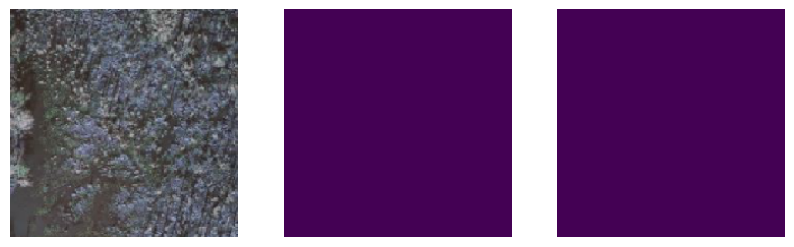

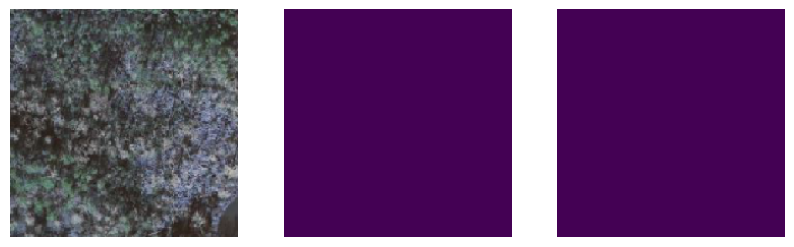

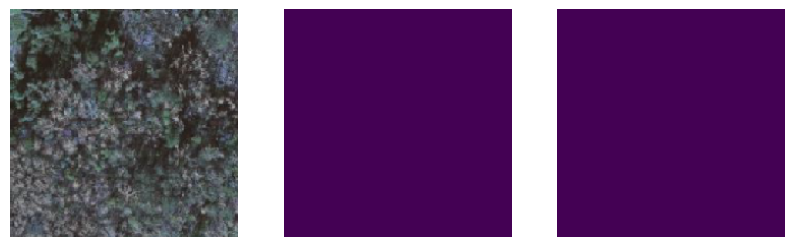

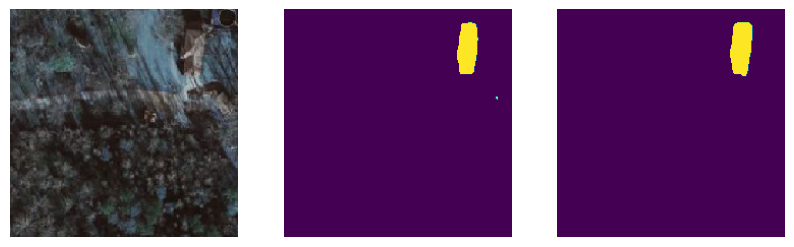

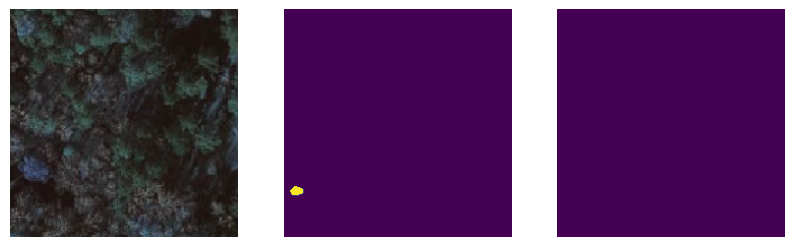

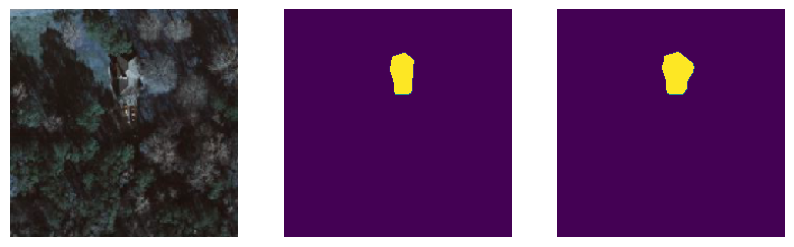

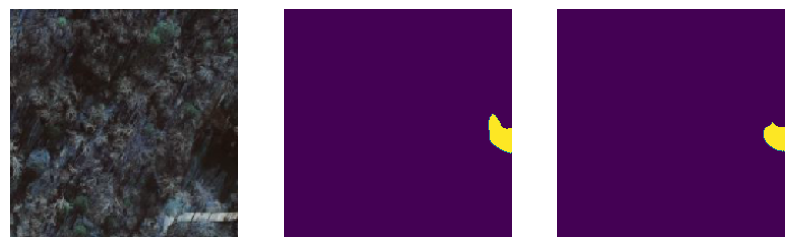

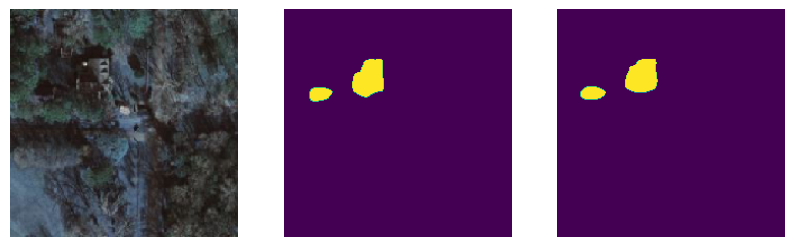

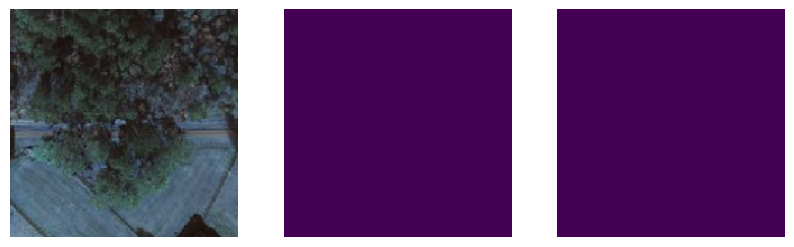

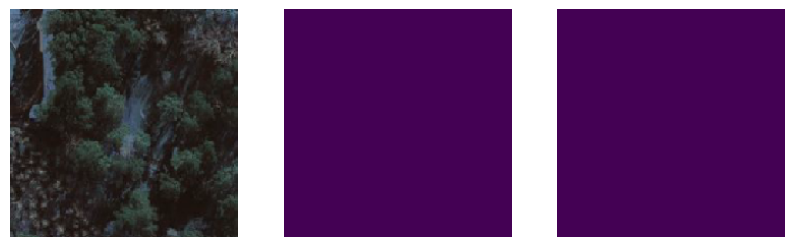

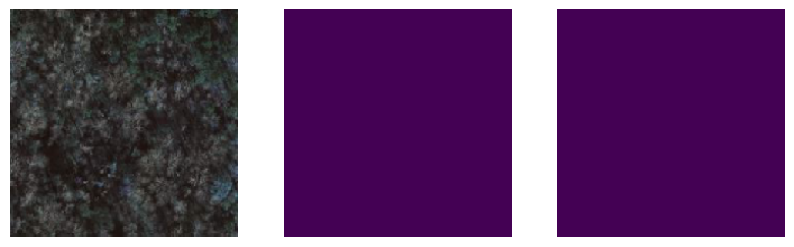

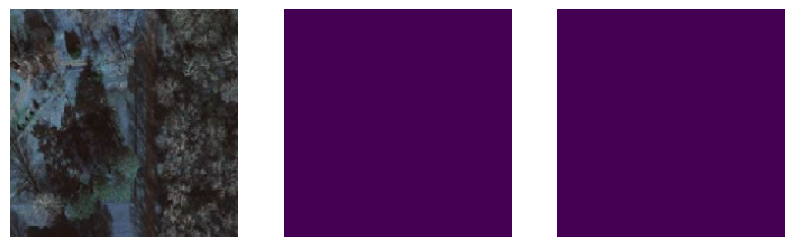

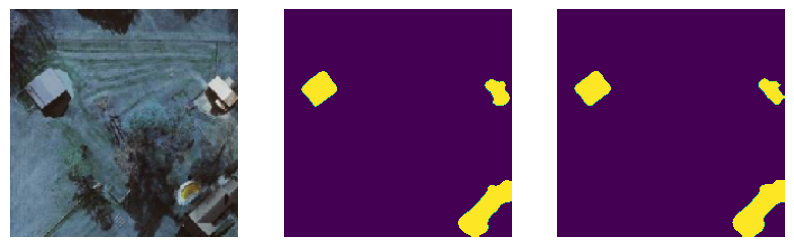

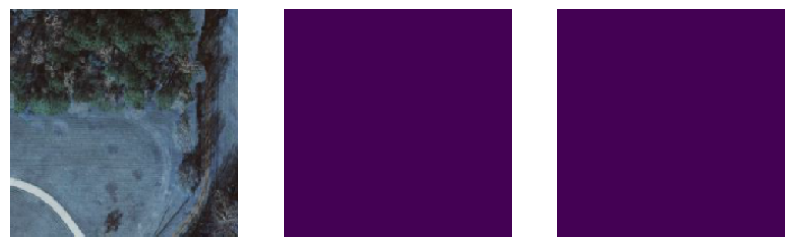

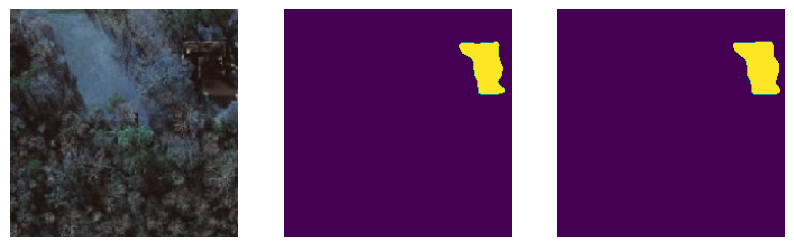

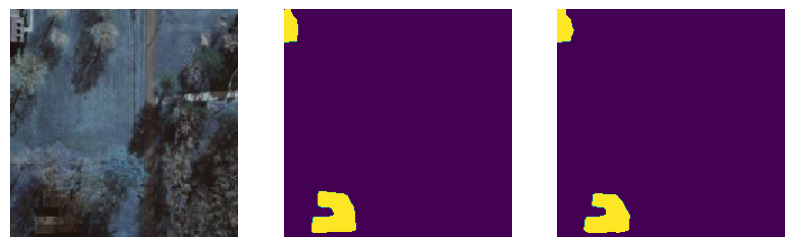

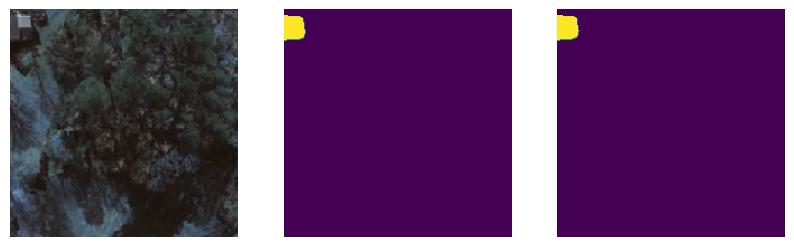

In [ ]:
test_data = pd.read_csv('test.csv')
submit1 = pd.read_csv('eff7+dicefocal+adamW+rand224_p1.csv')
submit2 = pd.read_csv('efficient7+dicefocal+adamW+random224+downscale(50,005).csv')

import matplotlib.pyplot as plt
for i in range(2320, 2370):
    test_image_path = test_data['img_path'][i]
    test_image = cv2.imread(test_image_path)
    test_mask1 = rle_decode(submit1['mask_rle'][i], (224,224))
    test_mask2 = rle_decode(submit2['mask_rle'][i], (224,224))

    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(test_image)
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(test_mask1)
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(test_mask2)
    plt.axis("off")